In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import NetworkOptimizer, fast_evaluator, evaluator, propagation_distance

In [19]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_33729/416890850.py:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)


In [57]:
spectral_radius = np.max(np.abs(np.linalg.eigvals(connectivity)))

In [58]:
spectral_radius

23.07012031659907

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_33729/416890850.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "propagation_distance" failed type inference due to: Use of unsupported NumPy function 'numpy.diag_indices' or unsupported use of the function.

File "../../../../../../../var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_33729/416890850.py", line 34:
<source missing, REPL/exec in use?>

During: typing of get attribute at /var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_33729/416890850.py (34)

File "../../../../../../../var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_33729/416890850.py", line 34:
<source missing, REPL/exec in use?>

  @jit(nopython=False)
/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "propagation_distance" was compiled in object mode wi

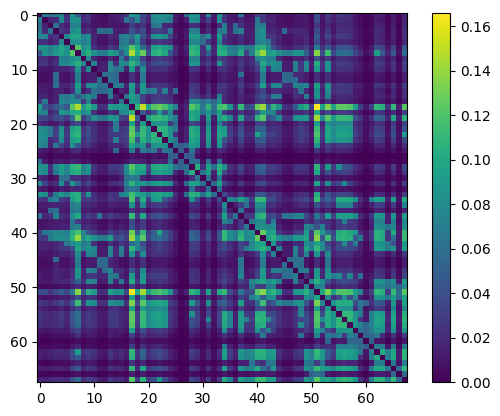

In [65]:
plt.imshow(propagation_distance(connectivity, coordinates))
plt.colorbar()

In [28]:
optimizer = NetworkOptimizer(
        coordinates=coordinates,
        empirical_network=connectivity,
        n_iterations=2600,
        distance_fn=communicability_distance,
        random_seed=11
    )
    
# Define parameter ranges
param_ranges = {
    'alpha': (0.8, 2),
}

# Run optimization
results = optimizer.optimize(
    param_ranges=param_ranges,
    n_calls=10,
    n_parallel_samples=1,
    verbose=True
)

Running Bayesian optimization...


Simulating network evolution:   0%|          | 0/2599 [00:00<?, ?it/s]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/generative.py:242: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/numba/core/typing/context.py", line 348, in resolve_module_constants
    attrval = getattr(typ.pymod, attr)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  distances = distance_fn(adjacency, coordinates)
Simulating network evolution:   0%|          | 0/2599 [00:00<?, ?it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Internal error at resolving type of attribute "expm" of "$50load_attr.4".
module 'numpy.linalg' has no attribute 'expm'
During: typing of get attribute at /var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_33729/2652191052.py (3)
Enable logging at debug level for details.

File "../../../../../../../var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_33729/2652191052.py", line 3:
<source missing, REPL/exec in use?>

During: resolving callee type: type(CPUDispatcher(<function communicability_distance at 0x109ec0ea0>))
During: typing of call at /Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/generative.py (242)

During: resolving callee type: type(CPUDispatcher(<function communicability_distance at 0x109ec0ea0>))
During: typing of call at /Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/generative.py (242)


File "generative.py", line 242:
def compute_node_payoff(
    <source elided>
    if alpha != 0:
        distances = distance_fn(adjacency, coordinates)
        ^


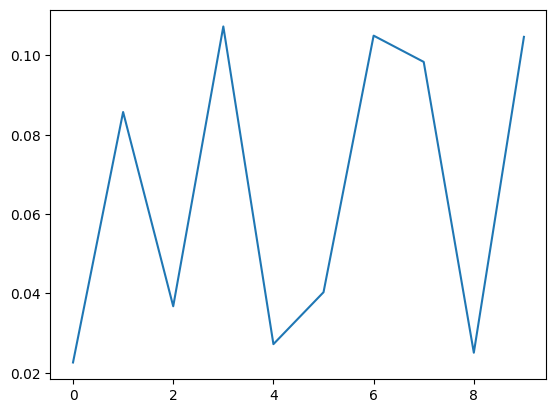

In [7]:
plt.plot(results.all_scores)

In [8]:
results.best_parameters

{'alpha': 0.8819682093215755}

In [9]:

# Create parameter trajectories
n_iterations = 5000
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, results.best_parameters['alpha'])
beta = np.full(n_iterations, 0.1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)

# Run simulation
history = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    distance_fn=gen.resistance_distance,
    alpha=alpha,
    beta=beta,
    noise=noise,
    connectivity_penalty=penalty,
    n_jobs=-1,  # Use all available cores
    random_seed=42,
    batch_size=16,
)

Simulating network evolution:   0%|          | 0/4999 [00:00<?, ?it/s]

Simulating network evolution: 100%|██████████| 4999/4999 [02:05<00:00, 39.77it/s]


In [10]:
np.sum(history[:,:,-1])/(connectivity.shape[0])**2

0.19698368728839644

In [11]:
np.sum(connectivity)/(connectivity.shape[0])**2

0.20098491843644198

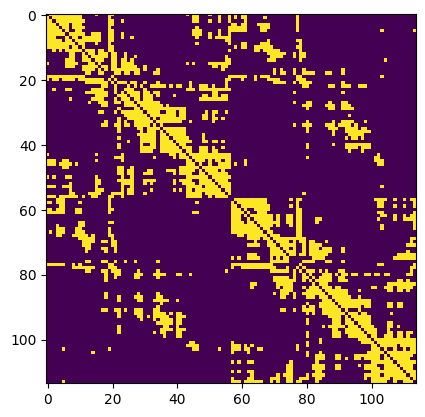

In [12]:
plt.imshow(history[:,:,-1])

In [13]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution:   0%|          | 0/5000 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 5000/5000 [01:16<00:00, 65.34it/s]


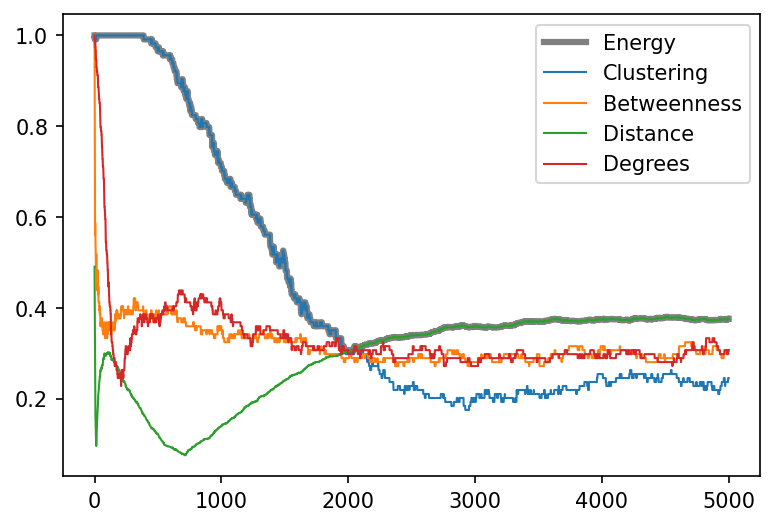

In [14]:
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(energy_vector,lw=3,label='Energy',color='gray')
plt.plot(clustering_vector,lw=1,label='Clustering')
plt.plot(betweenness_vector,lw=1,label='Betweenness')
plt.plot(distance_vector,lw=1,label='Distance')
plt.plot(degrees_vector,lw=1,label='Degrees')
plt.legend();

In [15]:
np.min(energy_vector)

0.30381526826050614

In [16]:
np.argmin(energy_vector)

2001

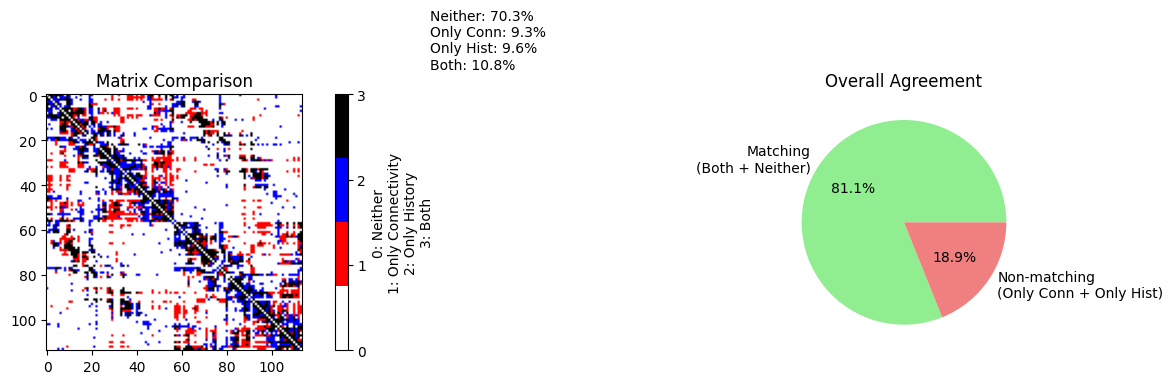

In [17]:
# Create a figure
plt.figure(figsize=(15, 4))

# Get the time point with minimum energy
min_energy_point = np.argmin(energy_vector)

# Create subplots
plt.subplot(121)
# Create a custom matrix where:
# 0: neither (white)
# 1: only connectivity (red)
# 2: only history (blue)
# 3: both (black)
comparison = connectivity.astype(int) + 2 * history[:,:,min_energy_point].astype(int)
plt.imshow(comparison, cmap=plt.cm.colors.ListedColormap(['white', 'red', 'blue', 'black']))
plt.title('Matrix Comparison')
plt.colorbar(ticks=[0, 1, 2, 3], 
            label='0: Neither\n1: Only Connectivity\n2: Only History\n3: Both')

# Add percentage text
total = connectivity.shape[0] * connectivity.shape[1]
neither = np.sum(comparison == 0) / total * 100
only_conn = np.sum(comparison == 1) / total * 100
only_hist = np.sum(comparison == 2) / total * 100
both = np.sum(comparison == 3) / total * 100

plt.text(1.5, 1.1, f'Neither: {neither:.1f}%\nOnly Conn: {only_conn:.1f}%\n'
         f'Only Hist: {only_hist:.1f}%\nBoth: {both:.1f}%', 
         transform=plt.gca().transAxes)

# Add second subplot for overlap percentage
plt.subplot(122)
labels = ['Matching\n(Both + Neither)', 'Non-matching\n(Only Conn + Only Hist)']
values = [(both + neither), (only_conn + only_hist)]
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Overall Agreement')

plt.tight_layout()

Evaluating network evolution: 100%|██████████| 5000/5000 [00:06<00:00, 792.43it/s]


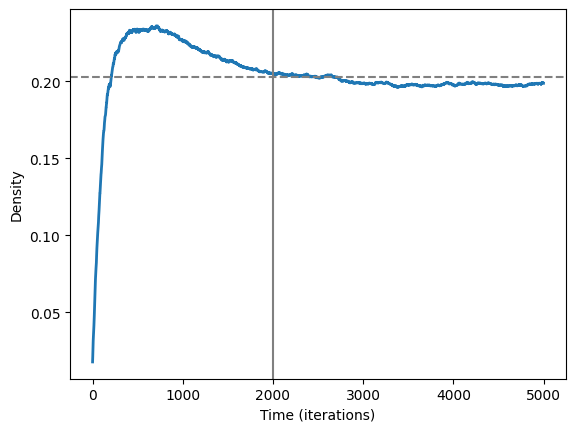

In [18]:
density = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(history[:,:,t]))

plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(connectivity))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(energy_vector), color='gray', linestyle='-')
